In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [3]:
TARGET_COLUMN = 'vocal_channel'
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

# Dataset preparation

In [4]:
try:
    excluded_prefixes = ['zc']
    columns_to_remove = []
    for column in df[numerical_attr_list].columns:
        if column.startswith(tuple(excluded_prefixes)) or column == TARGET_COLUMN:
            columns_to_remove.append(column)

    columns_to_remove;
    df = df.drop(columns=columns_to_remove, axis=1)
    
except KeyError as e:
    print(e)
    
for col in columns_to_remove:
    try:
        print(col)
        numerical_attr_list.remove(col)
    except ValueError as e:
        print(e, f"raised by column '{col}'")
        

zc_sum
zc_mean
zc_std
zc_kur
zc_skew
zc_mean_w1
zc_sum_w2
zc_skew_w2
zc_sum_w3
zc_kur_w3
zc_sum_w4
zc_mean_w4


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(df[numerical_attr_list])
y = pd.Categorical(df[TARGET_COLUMN]).codes

# print(f"numerical_attr_list is {numerical_attr_list}")
print(f"target variable: {np.unique(y, return_counts=True)}")
print(f"X has shape {X.shape}")

target variable: (array([0, 1], dtype=int8), array([1003, 1426]))
X has shape (2429, 231)


In [6]:
from sklearn.model_selection import train_test_split

# Divide in train, test, validation
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
test_mask = df.actor_number >= 19
df.drop(columns="actor_number", inplace=True)

X_test, y_test = X[test_mask], y[test_mask]

X_train, X_val, y_train, y_val = train_test_split(X[~test_mask], y[~test_mask], test_size=0.2)
print(f"Train: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

Train: (1449, 231)
Val: (363, 231)
Test: (617, 231)


# Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-07 15:33:28,394] A new study created in memory with name: no-name-4cbb7d52-9111-4b93-84a6-39087b7ff5e8
[W 2023-07-07 15:33:28,409] Trial 2 failed with parameters: {'penalty': 'elasticnet', 'C': 4.42738520340903, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logist

[I 2023-07-07 15:33:29,540] Trial 7 finished with value: 0.9889807162534435 and parameters: {'penalty': 'l2', 'C': 9.386302781714043, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.9889807162534435.
[W 2023-07-07 15:33:29,552] Trial 10 failed with parameters: {'penalty': 'elasticnet', 'C': 0.42054229917563296, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/

[W 2023-07-07 15:33:30,572] Trial 19 failed with value None.
[I 2023-07-07 15:33:31,084] Trial 20 finished with value: 0.9889807162534435 and parameters: {'penalty': 'l2', 'C': 8.73381315740257, 'solver': 'liblinear'}. Best is trial 1 with value: 0.9889807162534435.
[W 2023-07-07 15:33:31,122] Trial 21 failed with parameters: {'penalty': 'elasticnet', 'C': 4.9000451913415715, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver

[W 2023-07-07 15:33:31,544] Trial 25 failed with value None.
[W 2023-07-07 15:33:31,643] Trial 26 failed with parameters: {'penalty': 'elasticnet', 'C': 4.105283367810949, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-07-07 15:33:31,870] Trial 28 failed with value None.
[W 2023-07-07 15:33:31,896] Trial 29 failed with parameters: {'penalty': 'elasticnet', 'C': 4.713770170392337, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-07-07 15:33:32,045] Trial 31 failed with value None.
[W 2023-07-07 15:33:32,132] Trial 33 failed with parameters: {'penalty': 'elasticnet', 'C': 4.034478713764346, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-07 15:33:32,540] Trial 39 failed with value None.
[I 2023-07-07 15:33:32,551] Trial 17 finished with value: 0.9834710743801653 and parameters: {'penalty': 'none', 'C': 8.766779131481886, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.9889807162534435.
[W 2023-07-07 15:33:32,525] Trial 40 failed with parameters: {'penalty': 'elasticnet', 'C': 4.835538816535686, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_job

[W 2023-07-07 15:33:32,686] Trial 45 failed with parameters: {'penalty': 'elasticnet', 'C': 4.340044810654712, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penal

[W 2023-07-07 15:33:32,897] Trial 53 failed with parameters: {'penalty': 'elasticnet', 'C': 4.046887409525235, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penal

[W 2023-07-07 15:33:33,187] Trial 62 failed with parameters: {'penalty': 'elasticnet', 'C': 4.536105551853041, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penal

[W 2023-07-07 15:33:33,341] Trial 66 failed with value None.
[W 2023-07-07 15:33:33,345] Trial 68 failed with parameters: {'penalty': 'elasticnet', 'C': 3.894208482615168, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-07 15:33:33,449] Trial 69 failed with value None.
[W 2023-07-07 15:33:33,452] Trial 72 failed with value None.
[W 2023-07-07 15:33:33,472] Trial 70 failed with value None.
[W 2023-07-07 15:33:33,474] Trial 73 failed with parameters: {'penalty': 'elasticnet', 'C': 4.541060951530524, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/

[W 2023-07-07 15:33:33,646] Trial 80 failed with parameters: {'penalty': 'elasticnet', 'C': 4.494547803574437, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penal

[W 2023-07-07 15:33:33,768] Trial 82 failed with value None.
[W 2023-07-07 15:33:33,766] Trial 83 failed with value None.
[W 2023-07-07 15:33:33,796] Trial 85 failed with value None.
[W 2023-07-07 15:33:33,799] Trial 86 failed with parameters: {'penalty': 'elasticnet', 'C': 4.367716958864307, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/

[W 2023-07-07 15:33:33,923] Trial 89 failed with value None.
[W 2023-07-07 15:33:33,947] Trial 92 failed with parameters: {'penalty': 'elasticnet', 'C': 4.400302256351834, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-07 15:33:34,076] Trial 97 failed with value None.
[W 2023-07-07 15:33:34,071] Trial 95 failed with value None.
[W 2023-07-07 15:33:34,090] Trial 96 failed with parameters: {'penalty': 'elasticnet', 'C': 4.70984340311877, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model

[W 2023-07-07 15:33:34,145] Trial 94 failed with value None.
[W 2023-07-07 15:33:34,168] Trial 98 failed with value None.
[W 2023-07-07 15:33:34,170] Trial 100 failed with parameters: {'penalty': 'elasticnet', 'C': 4.031934610719725, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/par

[W 2023-07-07 15:33:34,353] Trial 102 failed with value None.
[W 2023-07-07 15:33:34,396] Trial 105 failed with value None.
[W 2023-07-07 15:33:34,415] Trial 106 failed with parameters: {'penalty': 'elasticnet', 'C': 4.300106074851796, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_m

[W 2023-07-07 15:33:34,532] Trial 111 failed with parameters: {'penalty': 'elasticnet', 'C': 4.5969270888311415, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pen

[W 2023-07-07 15:33:34,689] Trial 117 failed with parameters: {'penalty': 'elasticnet', 'C': 4.371610640148557, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pena

[W 2023-07-07 15:33:34,814] Trial 120 failed with value None.
[W 2023-07-07 15:33:34,842] Trial 123 failed with parameters: {'penalty': 'elasticnet', 'C': 4.234346065181908, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-07 15:33:34,975] Trial 126 failed with value None.
[W 2023-07-07 15:33:35,016] Trial 129 failed with parameters: {'penalty': 'elasticnet', 'C': 4.41612752310242, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-07 15:33:35,144] Trial 132 failed with value None.
[W 2023-07-07 15:33:35,119] Trial 133 failed with parameters: {'penalty': 'elasticnet', 'C': 4.235019625732752, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-07 15:33:35,282] Trial 136 failed with value None.
[W 2023-07-07 15:33:35,298] Trial 140 failed with parameters: {'penalty': 'elasticnet', 'C': 4.26979361145883, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-07 15:33:35,458] Trial 146 failed with value None.
[W 2023-07-07 15:33:35,454] Trial 143 failed with value None.
[W 2023-07-07 15:33:35,456] Trial 145 failed with value None.
[W 2023-07-07 15:33:35,452] Trial 142 failed with value None.
[W 2023-07-07 15:33:35,530] Trial 148 failed with parameters: {'penalty': 'elasticnet', 'C': 4.414562100614587, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

In [9]:
best_params = study.best_params
logr = LogisticRegression(**best_params)

# Trains on test AND validation
logr.fit(np.concatenate((X_train, X_val)), np.concatenate([y_train, y_val]))

y_pred_test = logr.predict(X_test)

from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 4.6342729146973, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       262
           1       1.00      0.92      0.96       355

    accuracy                           0.95       617
   macro avg       0.95      0.96      0.95       617
weighted avg       0.96      0.95      0.95       617

Accuracy 0.9546191247974068
F1-score [0.94909091 0.95906433]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

In [24]:
# Shows the decision boundaries in the embedding
def boundaries_on_UMAP(reducer, predictor, embedding=None, n_pts=30, **kwargs):
    global X, y, X_train, X_test,X_val, y_train, y_test, y_val
    cmap, title = kwargs.get("cmap", "viridis"), kwargs.get("title", "Decision boundaries on UMAP")
    if embedding is None:
        embedding =  reducer.fit_transform(X)
        
    # Genearate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    results = predictor.predict(points_in_gigaspace).reshape(old_shape)
    plt.contourf(XX, YY, results.T, cmap="viridis", alpha=0.6, levels=1)
    plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
    plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    plt.legend()
    plt.axis("off");
    plt.title(title);   

In [10]:
# Since making an embedding costs time:
from umap import UMAP

reducer = UMAP(n_neighbors=20)
embedding = reducer.fit_transform(X)

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

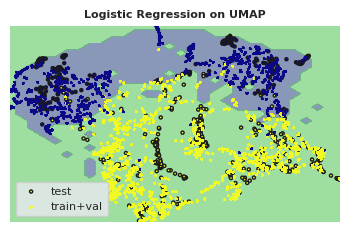

In [36]:
boundaries_on_UMAP(reducer, logr, embedding=embedding, title="Logistic Regression on UMAP", cmap="plasma")
plt.savefig("images/LogRegUMAP.pdf")

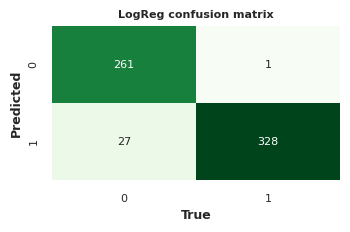

In [26]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LogReg confusion matrix')
plt.show()

# Suppport Vector Machine

## Linear SVM

In [30]:
from sklearn.svm import LinearSVC

In [31]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    
    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_train, y_train)
    
    y_pred = lin_svc.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-07 15:50:48,531] A new study created in memory with name: no-name-71bf3c76-d58c-4332-b811-7713448990d4
[W 2023-07-07 15:50:48,551] Trial 2 failed with parameters: {'penalty': 'l1', 'C': 1.0050281386208688, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.loc

[W 2023-07-07 15:50:49,184] Trial 11 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-07 15:50:49,431] Trial 6 finished with value: 0.977961432506887 and parameters: {'penalty': 'l2', 'C': 49.726051220493474, 'loss': 'hinge'}. Best is trial 1 with value: 0.9834710743801653.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-07 15:50:49,582] Trial 7 finished with value: 0.977961432506887 and parameters: {'penalty': 'l2', 'C': 84.05166489978092, 'loss': 'squared_hinge'}. Best is trial 1 with value: 0.9834710743801653.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conv

[W 2023-07-07 15:50:50,423] Trial 21 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-07 15:50:50,465] Trial 16 finished with value: 0.9724517906336089 and parameters: {'penalty': 'l2', 'C': 42.11226086120164, 'loss': 'squared_hinge'}. Best is trial 1 with value: 0.9834710743801653.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-07-07 15:50:50,471] Trial 22 failed with parameters: {'penalty': 'l1', 'C': 67.26223518955224, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penal

[W 2023-07-07 15:50:50,661] Trial 28 failed with parameters: {'penalty': 'l1', 'C': 64.91517777406396, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-07 15:50:50,814] Trial 32 failed with parameters: {'penalty': 'l1', 'C': 68.16152594160678, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-07 15:50:50,994] Trial 39 failed with value None.
[W 2023-07-07 15:50:50,969] Trial 38 failed with parameters: {'penalty': 'l1', 'C': 57.53863197088717, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-07 15:50:51,235] Trial 45 failed with parameters: {'penalty': 'l1', 'C': 53.25347226644841, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-07 15:50:51,365] Trial 49 failed with value None.
[W 2023-07-07 15:50:51,369] Trial 50 failed with parameters: {'penalty': 'l1', 'C': 67.47208300031905, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-07 15:50:51,605] Trial 57 failed with value None.
[W 2023-07-07 15:50:51,603] Trial 56 failed with parameters: {'penalty': 'l1', 'C': 62.72346091577366, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-07 15:50:51,754] Trial 61 failed with value None.
[W 2023-07-07 15:50:51,749] Trial 63 failed with value None.
[W 2023-07-07 15:50:51,744] Trial 60 failed with value None.
[W 2023-07-07 15:50:51,759] Trial 62 failed with parameters: {'penalty': 'l1', 'C': 60.86148396337259, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinea

[W 2023-07-07 15:50:52,035] Trial 69 failed with value None.
[W 2023-07-07 15:50:52,024] Trial 70 failed with parameters: {'penalty': 'l1', 'C': 63.225620969089235, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1

[W 2023-07-07 15:50:52,203] Trial 73 failed with value None.
[W 2023-07-07 15:50:52,207] Trial 75 failed with parameters: {'penalty': 'l1', 'C': 65.22044044144494, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-07 15:50:52,435] Trial 81 failed with parameters: {'penalty': 'l1', 'C': 67.36052008036049, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-07 15:50:52,596] Trial 87 failed with parameters: {'penalty': 'l1', 'C': 66.62941098416947, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-07 15:50:52,735] Trial 92 failed with value None.
[W 2023-07-07 15:50:52,761] Trial 90 failed with value None.
[W 2023-07-07 15:50:52,765] Trial 93 failed with parameters: {'penalty': 'l1', 'C': 66.39044032494469, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-07 15:50:52,957] Trial 98 failed with parameters: {'penalty': 'l1', 'C': 64.5546962850903, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_

[W 2023-07-07 15:50:53,161] Trial 103 failed with value None.
[W 2023-07-07 15:50:53,157] Trial 104 failed with value None.
[W 2023-07-07 15:50:53,214] Trial 106 failed with parameters: {'penalty': 'l1', 'C': 69.98888502033432, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqF

[W 2023-07-07 15:50:53,346] Trial 111 failed with parameters: {'penalty': 'l1', 'C': 70.52124374801342, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-07 15:50:53,499] Trial 115 failed with value None.
[W 2023-07-07 15:50:53,505] Trial 114 failed with value None.
[W 2023-07-07 15:50:53,508] Trial 117 failed with parameters: {'penalty': 'l1', 'C': 65.82709973665789, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqF

[W 2023-07-07 15:50:53,663] Trial 120 failed with value None.
[W 2023-07-07 15:50:53,668] Trial 121 failed with value None.
[W 2023-07-07 15:50:53,669] Trial 123 failed with parameters: {'penalty': 'l1', 'C': 68.51452016441131, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqF

[W 2023-07-07 15:50:53,834] Trial 127 failed with value None.
[W 2023-07-07 15:50:53,840] Trial 129 failed with parameters: {'penalty': 'l1', 'C': 62.49017048696453, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

[W 2023-07-07 15:50:54,055] Trial 135 failed with parameters: {'penalty': 'l1', 'C': 65.01418937803967, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-07 15:50:54,246] Trial 140 failed with value None.
[W 2023-07-07 15:50:54,198] Trial 139 failed with value None.
[W 2023-07-07 15:50:54,250] Trial 141 failed with parameters: {'penalty': 'l1', 'C': 63.12716811432202, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqF

[W 2023-07-07 15:50:54,450] Trial 147 failed with parameters: {'penalty': 'l1', 'C': 66.59839070247241, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_112249/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

In [33]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 48.112231720413675, 'loss': 'hinge'}
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       262
           1       0.99      0.93      0.96       355

    accuracy                           0.95       617
   macro avg       0.95      0.96      0.95       617
weighted avg       0.96      0.95      0.95       617

Accuracy 0.9529983792544571
F1-score [0.94698355 0.95778748]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


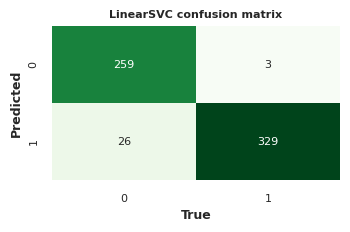

In [34]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

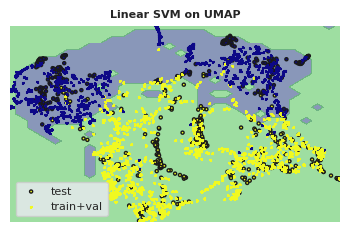

In [49]:
boundaries_on_UMAP(reducer, lin_svc, embedding=embedding, title="Linear SVM on UMAP", cmap="plasma")
plt.savefig("images/linear_SVM_UMAP.pdf")

In [46]:
decision_function = lin_svc.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]

TypeError: scatter() takes from 2 to 11 positional arguments but 570 were given

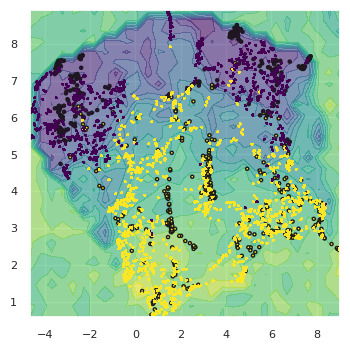

In [55]:
# Plots the decision function for diferent valus of C
for i, C in enumerate([0.02, 100]):
    plt.figure(figsize=default_style.HALFSIZE_FIGURE)

    cmap="viridis"
    clf = LinearSVC(C=C, loss="hinge", penalty='l2', random_state=42).fit(X_test, y_test)

    # Genearate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    results = clf.decision_function(points_in_gigaspace)
    plt.contourf(XX, YY, results.reshape(old_shape).T, cmap="viridis", alpha=0.6, levels=15)
    plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
    plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    
    # Plot support
    results = clf.decision_function(X_train)
    support_vector_indices = np.where((2 * y_train - 1) * results <= 1)[0]
    plt.scatter(*embedding[~test_mask][support_vector_indices], size=10, color="r")
    plt.axis("off")
#     decision_function = clf.decision_function(X_res_t)
# #     we can also calculate the decision function manually
# #     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
#     support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
#     support_vectors = X_res_t[support_vector_indices]
#     support_vectors_pca = pca.transform(support_vectors)

#     plt.subplot(1, 2, i + 1)
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
#     ax = plt.gca()
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
#     xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
#                          np.linspace(ylim[0], ylim[1], 50))
#     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
#     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
#                 linestyles=['--', '-', '--'])
#     plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
#                 linewidth=1, facecolors='none', edgecolors='k')
#     plt.title("C=" + str(C))
#     #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
# plt.tight_layout()
# plt.show()
    plt.savefig(f"images/linear_svm_UMAP_decision_function_C_{C}.pdf")

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.01,100)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

In [ ]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(X_res_t, y_res_t)

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

In [ ]:
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)

In [ ]:
support_vectors_pca = pca.transform(svc.support_vectors_)

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=10)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=10,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [ ]:
decision_function = svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [ ]:
support_vectors_pca = pca.transform(support_vectors)

In [ ]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=0.1, C=26)
    clf.fit(X_res_t, y_res_t)

    plt.figure()
    plt.clf()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
#     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
#                 zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X_pca[:, 0].min()
    x_max = X_pca[:, 0].max()
    y_min = X_pca[:, 1].min()
    y_max = X_pca[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    clf.fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [ ]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from scikeras.wrappers import KerasClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [ ]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    net.fit(X_res_t, y_res_t, epochs=50)
    y_pred = net.predict(X_res_v).astype(int)
#     print(y_pred.shape, y_res_v.shape)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

In [ ]:
best_params = study.best_params
par = {'n_features_in_': 231, 'n_classes_': 2}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(X_res_t, y_res_t,validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

In [ ]:
net.model_.summary()

In [ ]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
y_test_pred_proba = net.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

# Ensemble methods

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

In [ ]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(X_res_t, y_res_t)

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = rf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

In [ ]:
nbr_features = X_res_t.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

In [ ]:
sorted_idx = result.importances_mean.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import plot_tree

In [ ]:
rf.estimators_[0]

In [ ]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

In [ ]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [ ]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

In [ ]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(X_res_t, y_res_t)

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

In [ ]:
y_test_pred_proba = gb.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))